In [110]:
import geemap, ee
import geopandas as gpd
try:
        ee.Initialize()
except Exception as e:
        ee.Authenticate()
        ee.Initialize()

### Initialise area(s) of interest, and import shape file

In [159]:
# # file for Pakistan (later, use vector file from shape file to be exact)
pakistan = ee.Feature(ee.FeatureCollection("FAO/GAUL/2015/level0").filter(ee.Filter.eq('ADM0_NAME', 'Pakistan')).first()).geometry()
islamabad = ee.FeatureCollection("FAO/GAUL/2015/level1").filter(ee.Filter.eq("NAME_1", "Islamabad")).geometry()

import json
shp_path = "files/pakistan_shapefile/shape/Pakistan_Districts.shp"

# read shapefile into a geopands data frame and make sure it's initiated in the EPSG 4326 CRS
gdf = gpd.read_file(shp_path, crs='EPSG:4326')

# helper function to put the geodataframe in the right format for constructing an ee object
def shp_to_ee_fmt(geodf):
    data = json.loads(geodf.to_json())
    return data['features'][0]['geometry']['coordinates']

aoi = ee.Geometry.MultiPolygon(shp_to_ee_fmt(gdf))


### Visualise area of interest

In [112]:
long = 73.0479 # islamabad
lat = 33.6844
zoom_level = 7
# long = 65.167352 # Jhao?
# lat = 26.371142

map1 = geemap.Map(center=[lat,long], zoom=zoom_level)

dmsp1996 = ee.Image("NOAA/DMSP-OLS/NIGHTTIME_LIGHTS/F121996").select('stable_lights')
map1.addLayer(dmsp1996.mask(dmsp1996), {}, "DMSP-OLS 1996", opacity=0.75)
map1.addLayerControl()
map1


Map(center=[33.6844, 73.0479], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(chi…

TraitError: The 'east' trait of a Map instance expected a float, not the NoneType None.

#### Further inspection: Visualise DMSP dataset to see split view of differences between 1996 and 2010 around AOI

In [113]:
dmsp1996 = ee.Image("NOAA/DMSP-OLS/NIGHTTIME_LIGHTS/F101992")
dmsp2010 = ee.Image("NOAA/DMSP-OLS/NIGHTTIME_LIGHTS/F182010")

split_map = geemap.Map(center=[lat,long], zoom=zoom_level)

# generate tile layers
dmsp1996_tile = geemap.ee_tile_layer(dmsp1996.mask(dmsp1996), {}, 'DMSP-OLS 1996', opacity=0.75)
dmsp2010_tile = geemap.ee_tile_layer(dmsp2010.mask(dmsp2010), {}, 'DMSP-OLS 2010', opacity=0.75)

# create split map
split_map.split_map(left_layer=dmsp1996_tile, right_layer=dmsp2010_tile)
split_map

Map(center=[33.6844, 73.0479], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zo…

TraitError: The 'east' trait of a Map instance expected a float, not the NoneType None.

### Load DMSP data for statistical analysis

In [114]:
import pandas as pd

# 1992-2013
dmsp = ee.ImageCollection("NOAA/DMSP-OLS/NIGHTTIME_LIGHTS")

# basic inspection
# ref: https://worldbank.github.io/OpenNightLights/tutorials/mod3_1_DMSP-OLS_annual_composites.html
print(f"There are {dmsp.size().getInfo()} images in this collection.")

imgrange = dmsp.reduceColumns(ee.Reducer.minMax(), ["system:time_start"])
start = ee.Date(imgrange.get('min')).getInfo()['value']
end = ee.Date(imgrange.get('max')).getInfo()['value']
from datetime import datetime
start = datetime.utcfromtimestamp(start/1000).strftime('%Y-%m-%d %H:%M:%S')
end = datetime.utcfromtimestamp(end/1000).strftime('%Y-%m-%d %H:%M:%S')
print(f"Date range: {start, end}")

There are 35 images in this collection.
Date range: ('1992-01-01 00:00:00', '2013-01-01 00:00:00')


In [115]:
# view all properties in a given image (adding year to properties printed out)
# print(dmsp.limit(1))

#### Inspect data to determine whether to use mean or median when reducing

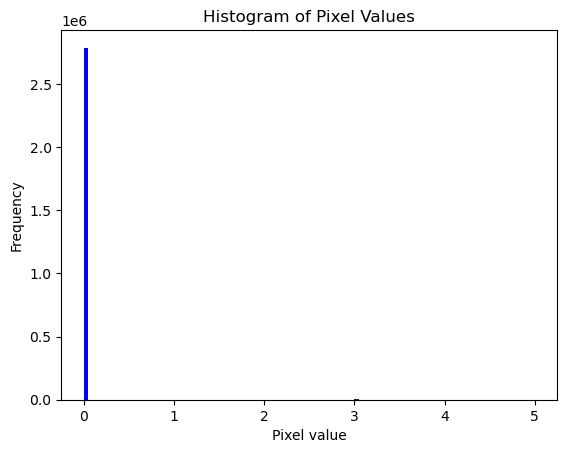

In [160]:
# using sample image from 2000
image = dmsp.filterDate('2000-01-01', '2000-12-31').select('stable_lights').first()

# Get the pixel values as a list
pixel_values = image.reduceRegion(reducer=ee.Reducer.toList(), 
                                   geometry=aoi, 
                                   scale=100, 
                                   maxPixels=1e9).get('stable_lights').getInfo()

plt.hist(pixel_values, bins=100, color='blue')
plt.xlabel('Pixel value')
plt.ylabel('Frequency')
plt.title('Histogram of Pixel Values')
plt.show()

#### notes:
From the histogram plot, the data is grealty skewed. We would need to use the median when reducing by region.

### Extract the mean radiance value for each month from the DMSP collection 

In [161]:
# # Apply the calibration to the DMSP images for 2010 to 2016
# calib_coeffs = ee.Image("files/Elvidge_DMSP_intercalib_coef.csv")
# dmsp = dmsp.map(lambda img: img.multiply(calib_coeffs).float())
# dmsp = dmsp.filterDate("2010-01-01", "2016-12-31")

dmsp_dates = []
dmsp_values = []
       
for year in range(1996, 2014):
    year_start = str(year) + "-01-01"
    year_end = str(year) + "-12-31"
    print(f"gettting data for {year_start}")
    image = dmsp.filterDate(year_start, year_end).select('stable_lights').first()
    value = image.reduceRegion(reducer=ee.Reducer.median(),
                                geometry=aoi,
                                scale=100,
                                maxPixels=1e9
                              ).get('stable_lights').getInfo()
    for month in range(1, 13):
        dmsp_dates.append(str(year_start) + "-" + str(month).zfill(2) + "-01")
        dmsp_values.append(value)

gettting data for 1996-01-01
gettting data for 1997-01-01
gettting data for 1998-01-01
gettting data for 1999-01-01
gettting data for 2000-01-01
gettting data for 2001-01-01
gettting data for 2002-01-01
gettting data for 2003-01-01
gettting data for 2004-01-01
gettting data for 2005-01-01
gettting data for 2006-01-01
gettting data for 2007-01-01
gettting data for 2008-01-01
gettting data for 2009-01-01
gettting data for 2010-01-01
gettting data for 2011-01-01
gettting data for 2012-01-01
gettting data for 2013-01-01


#### create a df based on the above dmsp data for initial analysis

In [163]:
import pandas as pd

dmsp_df = pd.DataFrame({"dates": dmsp_dates, "values": dmsp_values})
dmsp_df["dates"] = pd.to_datetime(dmsp_df["dates"])
dmsp_df.set_index("dates", inplace=True)

dmsp_df

,values
dates,
1996-01-01 01:00:00-01:00,0
1996-01-01 02:00:00-01:00,0
1996-01-01 03:00:00-01:00,0
1996-01-01 04:00:00-01:00,0
1996-01-01 05:00:00-01:00,0
...,...
2013-01-01 08:00:00-01:00,0
2013-01-01 09:00:00-01:00,0
2013-01-01 10:00:00-01:00,0


In [164]:
# Find the month with the highest value
max_value_month = dmsp_df["values"].idxmax().month
print("Month with the highest value:", max_value_month)

# Find general trends
trend = dmsp_df.groupby(dmsp_df.index.month).mean()
print("General trends:")
print(trend)

# Find the mean value
mean_value = dmsp_df["values"].mean()
print("Mean value:", mean_value)

Month with the highest value: 1
General trends:
       values
dates        
1         0.0
Mean value: 0.0


#### plot timeseries for DMSP over the years

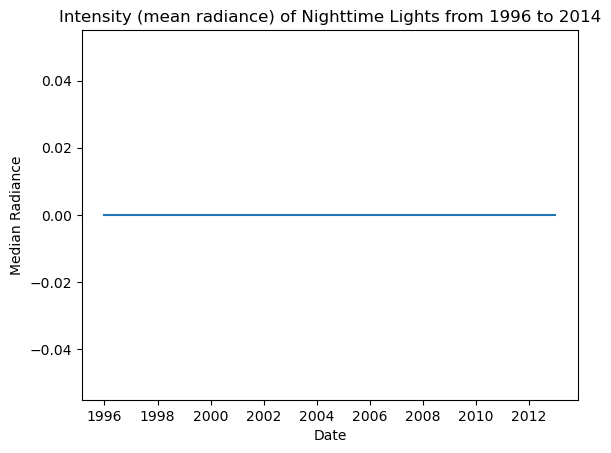

In [165]:
plt.plot(dmsp_df['values'])
plt.xlabel('Date')
plt.ylabel('Median Radiance')
plt.title('Intensity (mean radiance) of Nighttime Lights from 1996 to 2014')
plt.show()

### Load VIIRS data and extract the mean radiance value for each month from the  collection 

In [176]:
viirs = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMSLCFG")

viirs_dates = []
viirs_values = []

for year in range(2018, 2021): # note: times out after 2016. 2016 data has an issue so it was skipped. but it should not have a big effect
    for month in range(1, 13):
        start_date = str(year) + "-" + str(month).zfill(2) + "-01"
        print(f"gettting data for {start_date}")
        if month == 12:
            end_year = year + 1
            end_month = 1
        else:
            end_year = year
            end_month = month + 1
        end_date = str(end_year) + "-" + str(end_month).zfill(2) + "-01"
        image = viirs.filterDate(start_date, end_date).select('avg_rad').first()
        value = image.reduceRegion(reducer=ee.Reducer.median(),
                                     geometry=aoi,
                                     scale=100,
                                     maxPixels=1e9
                                  ).get("avg_rad").getInfo()
        viirs_dates.append(start_date)
        viirs_values.append(value)           


gettting data for 2018-01-01
gettting data for 2018-02-01
gettting data for 2018-03-01
gettting data for 2018-04-01
gettting data for 2018-05-01
gettting data for 2018-06-01
gettting data for 2018-07-01
gettting data for 2018-08-01
gettting data for 2018-09-01
gettting data for 2018-10-01
gettting data for 2018-11-01
gettting data for 2018-12-01
gettting data for 2019-01-01
gettting data for 2019-02-01
gettting data for 2019-03-01
gettting data for 2019-04-01
gettting data for 2019-05-01
gettting data for 2019-06-01
gettting data for 2019-07-01
gettting data for 2019-08-01
gettting data for 2019-09-01
gettting data for 2019-10-01
gettting data for 2019-11-01
gettting data for 2019-12-01
gettting data for 2020-01-01
gettting data for 2020-02-01
gettting data for 2020-03-01
gettting data for 2020-04-01
gettting data for 2020-05-01
gettting data for 2020-06-01
gettting data for 2020-07-01
gettting data for 2020-08-01
gettting data for 2020-09-01
gettting data for 2020-10-01
gettting data 

#### create a df based on the above viirs data for initial analysis

In [177]:
import pandas as pd

viirs_df = pd.DataFrame({"dates": viirs_dates, "values": viirs_values})
viirs_df["dates"] = pd.to_datetime(viirs_df["dates"])
viirs_df.set_index("dates", inplace=True)

viirs_df


,values
dates,
2014-01-01,0.017579
2014-02-01,0.072298
2014-03-01,0.090814
2014-04-01,0.145503
2014-05-01,0.075196
...,...
2020-08-01,0.310000
2020-09-01,0.320000
2020-10-01,0.290000


In [178]:
# Find the month with the highest value
max_value_month = viirs_df["values"].idxmax().month
print("Month with the highest value:", max_value_month)

# Find general trends
trend = viirs_df.groupby(viirs_df.index.month).mean()
print("General trends:")
print(trend)

# Find the mean value
mean_value = viirs_df["values"].mean()
print("Mean value:", mean_value)

Month with the highest value: 10
General trends:
         values
dates          
1      0.066615
2      0.175410
3      0.202759
4      0.266793
5      0.212282
6      0.177890
7      0.208783
8      0.206142
9      0.247290
10     0.230661
11     0.155985
12     0.107263
Mean value: 0.18815604193831426


#### plot timeseries for VIIRS over the years

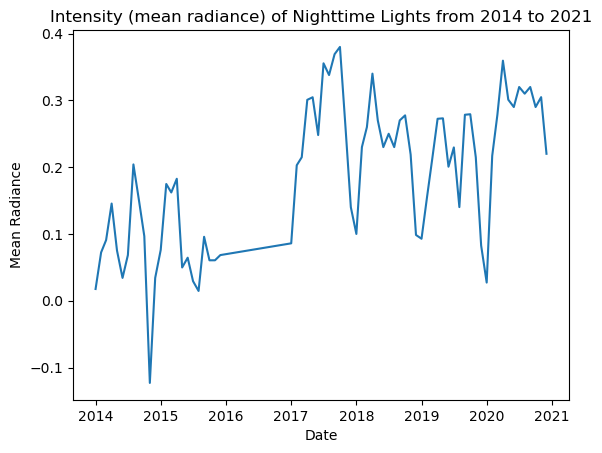

In [179]:
plt.plot(viirs_df['values'])
plt.xlabel('Date')
plt.ylabel('Mean Radiance')
plt.title('Intensity (mean radiance) of Nighttime Lights from 2014 to 2021')
plt.show()

### Create combined df with the extracted values from dmsp and viirs

In [184]:
# Create a pandas dataframe with the extracted values
dates = dmsp_dates + viirs_dates
datasets = ["DMSP"] * (18 * 12) + ["VIIRS"] * (6 * 12)
values = dmsp_values + viirs_values
data = {"Date": dates, "Dataset": datasets, "Median Radiance": values}
combined_df = pd.DataFrame(data)
combined_df["Date"] = pd.to_datetime(combined_df["Date"])
combined_df

,Date,Dataset,Median Radiance
0,1996-01-01 01:00:00-01:00,DMSP,0.000000
1,1996-01-01 02:00:00-01:00,DMSP,0.000000
2,1996-01-01 03:00:00-01:00,DMSP,0.000000
3,1996-01-01 04:00:00-01:00,DMSP,0.000000
4,1996-01-01 05:00:00-01:00,DMSP,0.000000
...,...,...,...
283,2020-08-01 00:00:00,VIIRS,0.310000
284,2020-09-01 00:00:00,VIIRS,0.320000
285,2020-10-01 00:00:00,VIIRS,0.290000
286,2020-11-01 00:00:00,VIIRS,0.304806


### plot

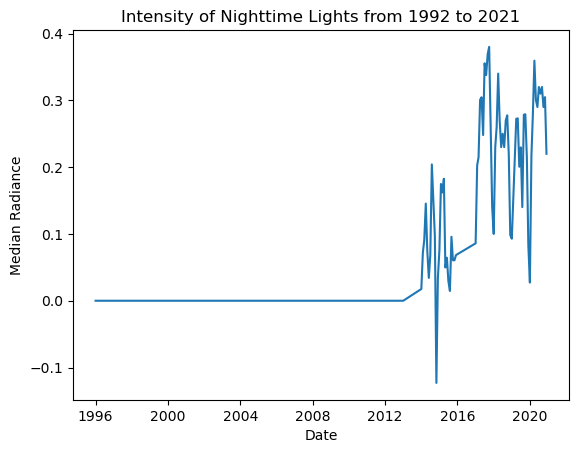

In [186]:
# Plot the mean radiance values for the two datasets
plt.plot(combined_df['Date'], combined_df['Median Radiance'])
plt.xlabel('Date')
plt.ylabel('Median Radiance')
plt.title('Intensity of Nighttime Lights from 1992 to 2021')
plt.show()
